In [17]:
import sys
import matplotlib.pyplot as plt

sys.path.append('..')
sys.path.append('.')

from src.utils.data_utils import get_cifar_data
from src.main.main import run_single_experiment
from inspect import signature

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

## Use CIFAR-10 image data for experiments

In [3]:
(x_train, y_train), (x_test, y_test) = get_cifar_data()

## Examine a few sampels of the data

<Figure size 432x288 with 0 Axes>

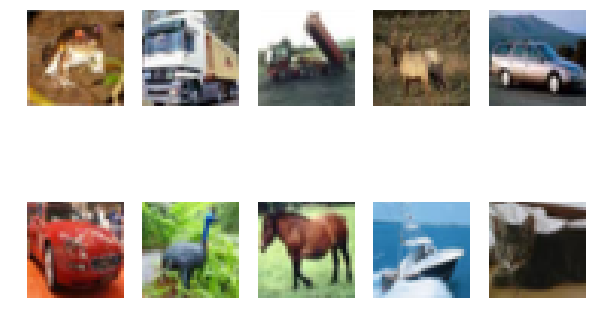

In [4]:
n_samples=10
plt.figure()
plt.figure(figsize=(10, 10))
for i in range(n_samples):
    ax = plt.subplot(n_samples // 5 + 1, 5, i + 1)
    plt.imshow(x_train[i,:])
    ax.axis('off')
plt.show()

## Set our experimental parameters

In [6]:
data_samples = 1000
monte_carlo_samples = 5

In [7]:
y_true, prediction_df, stochastic_predictions = run_single_experiment(data_samples,
                                                                     monte_carlo_samples)

Train on 900 samples, validate on 100 samples
Epoch 1/1
900/900 [==============================] - 2s 2ms/step - loss: 3.0504 - acc: 0.1578 - val_loss: 2.8458 - val_acc: 0.1100
Evaluating Model...
10000/10000 [==============================] - 3s 313us/step
Generating standard predictions...
10000/10000 [==============================] - 3s 270us/step
Generating stochastic predictions,

            this is the slow bit... 

Took this amount of seconds:
23.4311580657959
Saving predictions
Calculating means etc...


../src/controller/train_model.py:95: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  stoch_preds.set_value(index=i, col=0, value=Yt_hat[:, 0, i, 0].mean())
../src/controller/train_model.py:96: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  stoch_preds.set_value(index=i, col=1, value=Yt_hat[:, 0, i, 1].mean())
../src/controller/train_model.py:97: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  stoch_preds.set_value(index=i, col=2, value=Yt_hat[:, 0, i, 2].mean())
../src/controller/train_model.py:98: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  stoch_preds.set_value(index=i, col=3, value=Yt_hat[:, 0, i, 3].mean())
../src/controller/train_model.py:99: FutureWarning: set_valu

Standard confusion matrix: 
 col_0  0  1  2    3    4  5  6   8
row_0                             
0      1  1  0   66  850  0  0  82
1      0  8  0  180  801  0  0  11
2      0  1  0   24  963  0  0  12
3      0  1  0   41  956  0  1   1
4      0  0  0   14  980  0  0   6
5      0  0  1   53  944  0  0   2
6      0  0  0    5  995  0  0   0
7      0  1  0   31  963  1  0   4
8      0  1  0   77  849  0  0  73
9      0  6  0  140  848  0  0   6
Bayesian confusion matrix: 
 col_0    0    1   2   3    4    5    6    7    8    9
row_0                                                
0      190  107  13  26   47   52   56   97  299  113
1       57  271   5  71   56   48  114   57  139  182
2       68   72  44  44  200   68  228  128   87   61
3       45  112  31  91  151  121  226  137   29   57
4       23   65  39  50  255   69  289  127   48   35
5       35  109  30  63  122  164  238  147   40   52
6       25   81  35  40  200   66  376  131   12   34
7       71   81  24  47  129   94  1

## Plot precision recall curves for a given target class (0-9)

In [59]:
target_class = 8

In [60]:
indicator_list = [1 if x == target_class else 0 for x in y_true]

In [61]:

precision, recall, _ = precision_recall_curve(indicator_list,
                                                prediction_df[target_class],
                                                pos_label=1)
precision_stoch, recall_stoch, _ = precision_recall_curve(indicator_list,
                           stochastic_predictions[target_class],
                           pos_label=1)

average_precision = average_precision_score(indicator_list,
                                            prediction_df[target_class])

average_precision_stoch = average_precision_score(indicator_list,
                                                  stochastic_predictions[target_class])

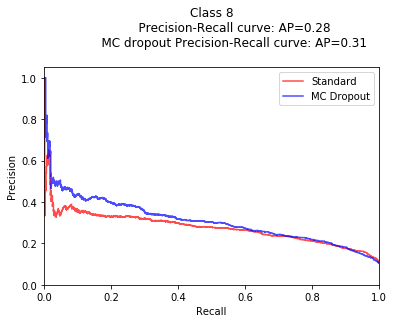

In [67]:
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='r', alpha=0.7,
         where='post', label = "Standard")

plt.step(recall_stoch, precision_stoch, color='b', alpha=0.7,
         where='post', label = "MC Dropout")


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title("""Class {0}
            Precision-Recall curve: AP={1:0.2f}
            MC dropout Precision-Recall curve: AP={2:0.2f}\n""".format(
          target_class, average_precision, average_precision_stoch))
plt.legend(loc='upper right')

plt.savefig('class8.png')